In [6]:
# ============================================
# EMOTION CLASSIFICATION WITH MLP
# ============================================
# Competition: CSI ML Sprint 2026
# Task: Multi-class emotion classification (6 classes)
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Emotion mapping
emotions = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}
emotions_reverse = {v: k for k, v in emotions.items()}

print("=" * 50)
print("DATASET OVERVIEW")
print("=" * 50)
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"\nTrain columns: {train_df.columns.tolist()}")
print(f"Test columns: {test_df.columns.tolist()}")
print(f"\nMissing values in train:\n{train_df.isnull().sum()}")
print(f"\nMissing values in test:\n{test_df.isnull().sum()}")
print(f"\nSample data:")
train_df.head(100)


DATASET OVERVIEW
Training samples: 9961
Test samples: 2000

Train columns: ['id', 'text', 'label']
Test columns: ['id', 'text ']

Missing values in train:
id       0
text     0
label    0
dtype: int64

Missing values in test:
id       0
text     0
dtype: int64

Sample data:


,id,text,label
0,1,i didnt feel humiliated 😔,0
1,2,i can go from feeling so hopeless 😞 to so damn...,0
2,3,im grabbing a minute to post i feel greedy 🤑 w...,3
3,4,i am ever feeling nostalgic 🕰️ about the firep...,2
4,5,i am feeling grouchy 😠,3
...,...,...,...
95,96,i feel like its perfect ✨ i even know trends 📈,1
96,97,i specifically wanted tango 💃 was feeling shy ...,4
97,98,i also didn t feel very weird 🤨 sleeping in my...,4
98,99,being all cooped up 🏠 and restless 😩 has made ...,0


## 1. Exploratory Data Analysis (EDA)

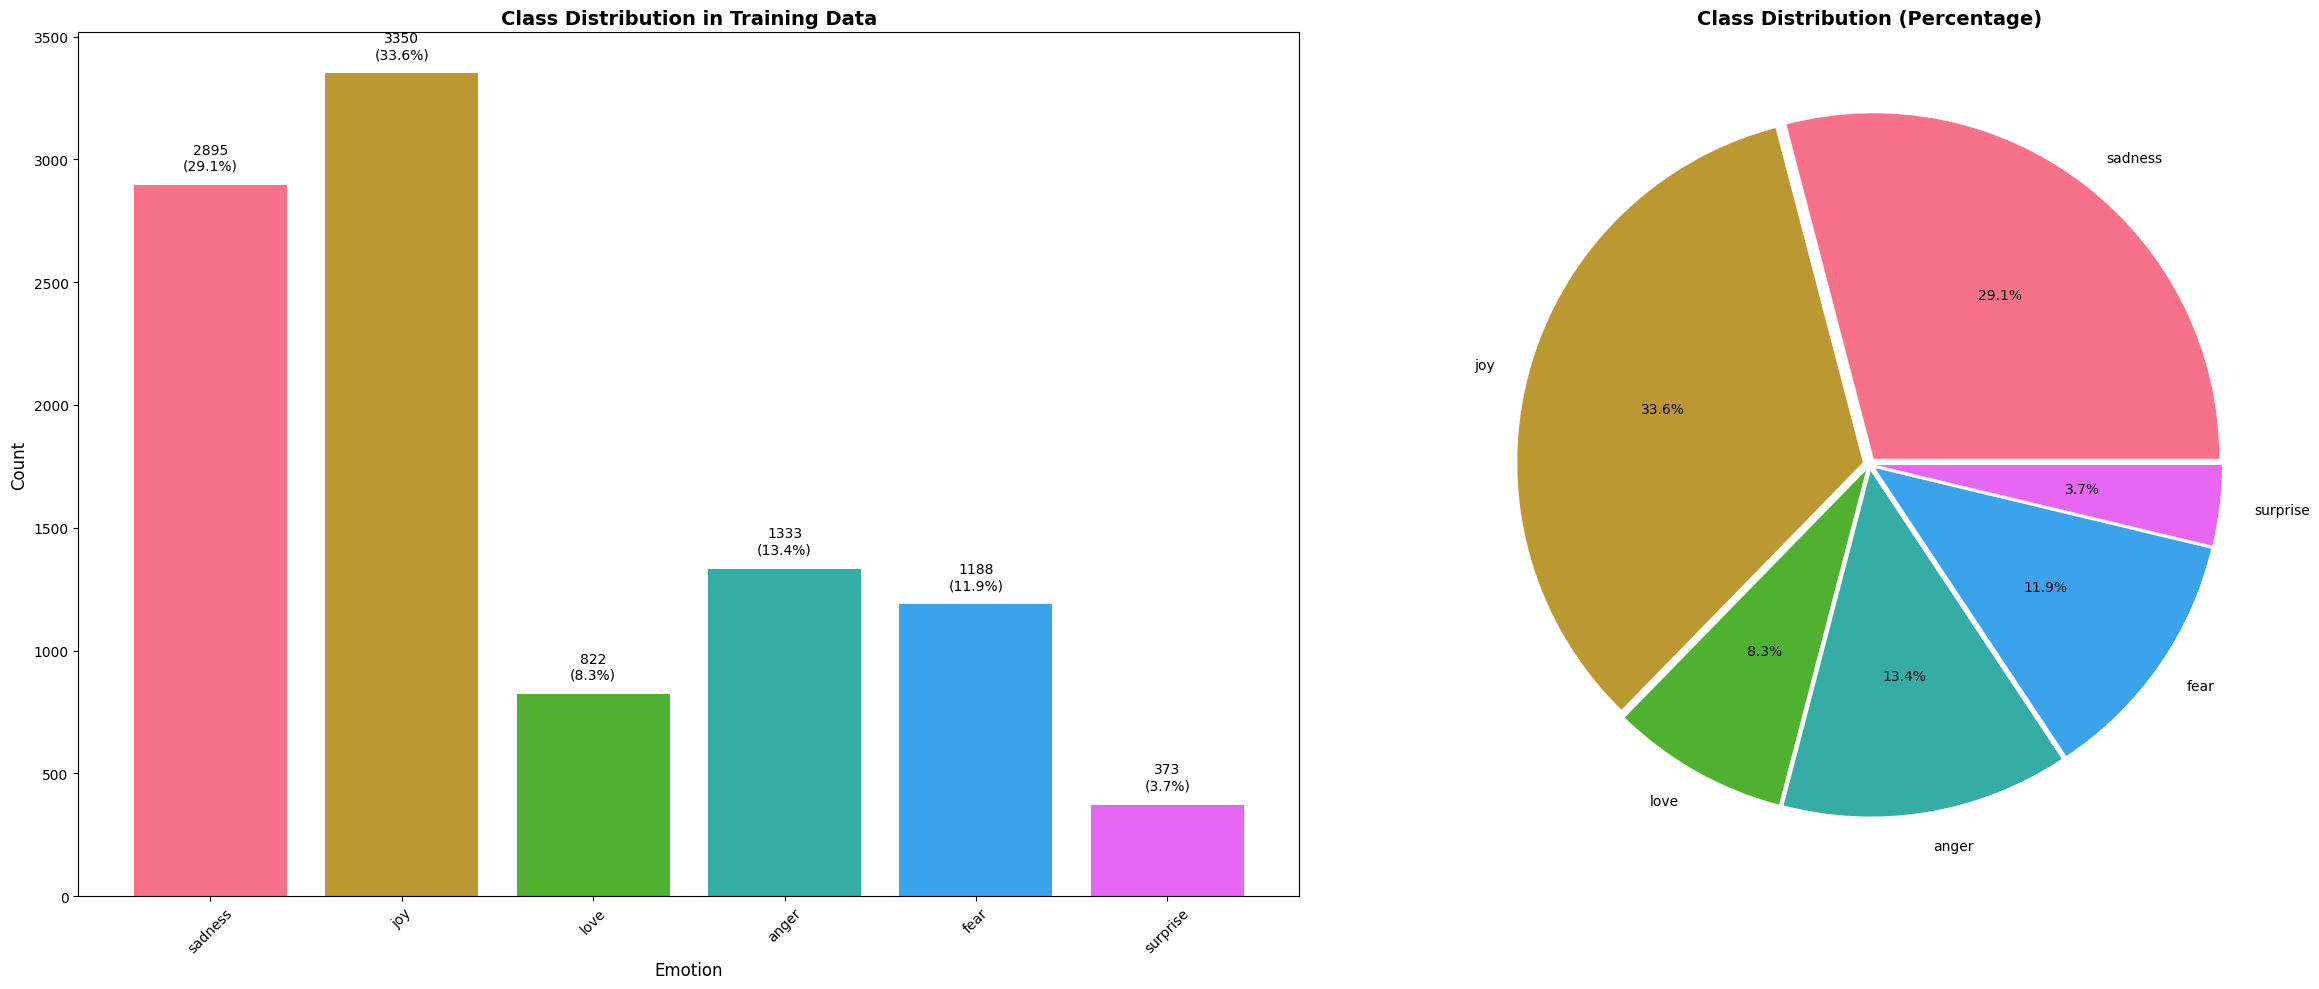


CLASS IMBALANCE ANALYSIS
Class counts:
label
0    2895
1    3350
2     822
3    1333
4    1188
5     373
Name: count, dtype: int64

Imbalance ratio (max/min): 8.98
Most common: joy (3350 samples)
Least common: surprise (373 samples)


In [11]:
# ============================================
# 1.1 CLASS DISTRIBUTION ANALYSIS
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(25, 10))

# Count plot
class_counts = train_df['label'].value_counts().sort_index()
colors = sns.color_palette("husl", 6)

ax1 = axes[0]
bars = ax1.bar([emotions[i] for i in class_counts.index], class_counts.values, color=colors)
ax1.set_xlabel('Emotion', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Class Distribution in Training Data', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, count in zip(bars, class_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{count}\n({count/len(train_df)*100:.1f}%)',
             ha='center', va='bottom', fontsize=10)

# Pie chart
ax2 = axes[1]
ax2.pie(class_counts.values, labels=[emotions[i] for i in class_counts.index],
        autopct='%1.1f%%', colors=colors, explode=[0.02]*6)
ax2.set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Check for class imbalance
print("\n" + "=" * 50)
print("CLASS IMBALANCE ANALYSIS")
print("=" * 50)
print(f"Class counts:\n{class_counts}")
print(f"\nImbalance ratio (max/min): {class_counts.max()/class_counts.min():.2f}")
print(f"Most common: {emotions[class_counts.idxmax()]} ({class_counts.max()} samples)")
print(f"Least common: {emotions[class_counts.idxmin()]} ({class_counts.min()} samples)")


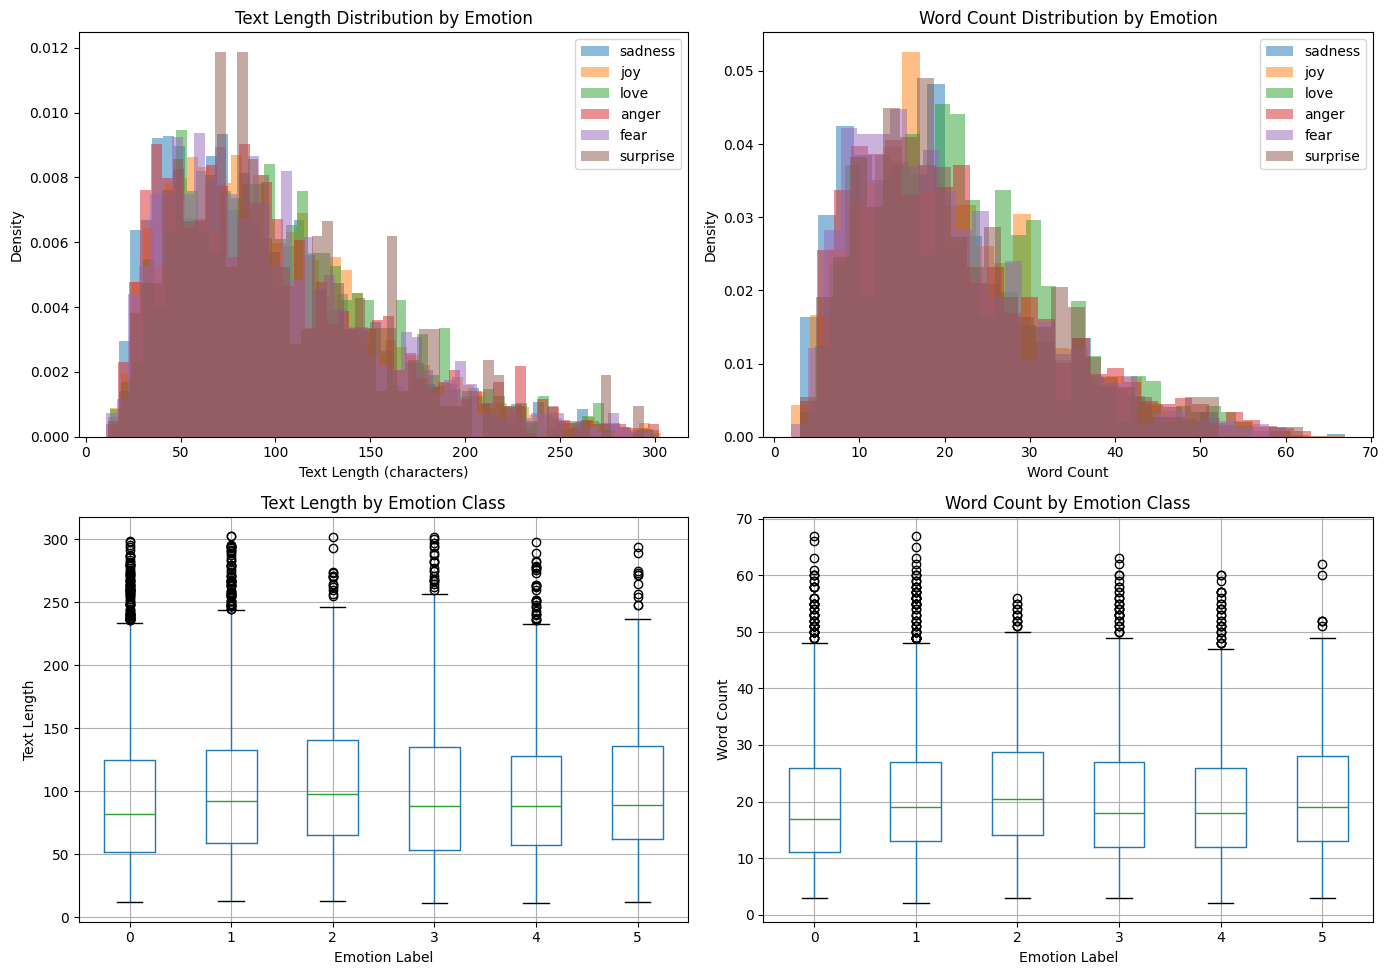


TEXT LENGTH STATISTICS BY EMOTION
      text_length                 word_count               
             mean    std min  max       mean    std min max
label                                                      
0           95.66  56.07  12  299      19.67  11.13   3  67
1          101.68  54.95  13  303      20.82  10.83   2  67
2          107.21  54.54  13  302      22.07  10.70   3  56
3          100.43  58.80  11  302      20.68  11.78   3  63
4           98.54  54.51  11  298      20.02  10.88   2  60
5          104.01  56.97  12  294      21.08  11.17   3  62


In [15]:
# ============================================
# 1.2 TEXT LENGTH ANALYSIS
# ============================================

# Clean column names in test_df to remove any trailing spaces
test_df.columns = test_df.columns.str.strip()

# Add text length features
train_df['text_length'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['text_length'] = test_df['text'].apply(len)
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Text length distribution by emotion
ax1 = axes[0, 0]
for label in sorted(train_df['label'].unique()):
    subset = train_df[train_df['label'] == label]['text_length']
    ax1.hist(subset, bins=50, alpha=0.5, label=emotions[label], density=True)
ax1.set_xlabel('Text Length (characters)')
ax1.set_ylabel('Density')
ax1.set_title('Text Length Distribution by Emotion')
ax1.legend()

# Word count distribution by emotion
ax2 = axes[0, 1]
for label in sorted(train_df['label'].unique()):
    subset = train_df[train_df['label'] == label]['word_count']
    ax2.hist(subset, bins=30, alpha=0.5, label=emotions[label], density=True)
ax2.set_xlabel('Word Count')
ax2.set_ylabel('Density')
ax2.set_title('Word Count Distribution by Emotion')
ax2.legend()

# Box plot for text length
ax3 = axes[1, 0]
train_df.boxplot(column='text_length', by='label', ax=ax3)
ax3.set_xlabel('Emotion Label')
ax3.set_ylabel('Text Length')
ax3.set_title('Text Length by Emotion Class')
plt.suptitle('')

# Box plot for word count
ax4 = axes[1, 1]
train_df.boxplot(column='word_count', by='label', ax=ax4)
ax4.set_xlabel('Emotion Label')
ax4.set_ylabel('Word Count')
ax4.set_title('Word Count by Emotion Class')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Statistics
print("\n" + "=" * 50)
print("TEXT LENGTH STATISTICS BY EMOTION")
print("=" * 50)
print(train_df.groupby('label').agg({
    'text_length': ['mean', 'std', 'min', 'max'],
    'word_count': ['mean', 'std', 'min', 'max']
}).round(2))

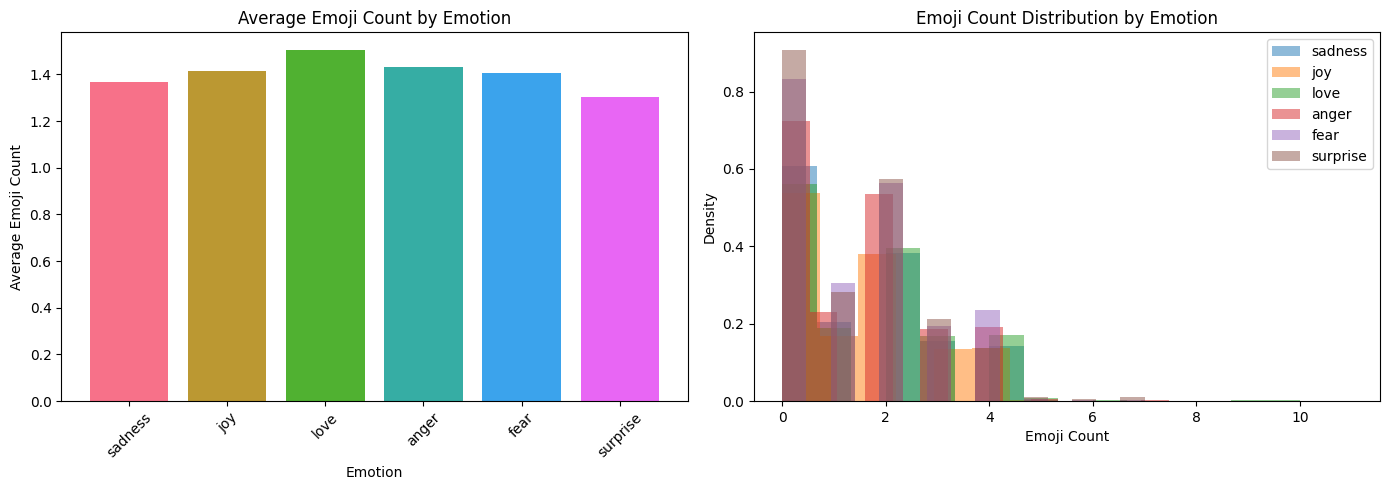


EMOJI STATISTICS
Samples with emojis: 6027 (60.5%)
Average emojis per sample: 1.41

Emoji count by emotion:
       mean   std  max
label                 
0      1.37  1.39   10
1      1.41  1.41   11
2      1.50  1.47   10
3      1.43  1.40    8
4      1.41  1.39    7
5      1.30  1.39    7


In [18]:
# ============================================
# 1.3 EMOJI ANALYSIS (Important for this dataset!)
# ============================================
import re
import emoji

def extract_emojis(text):
    """Extract all emojis from text"""
    return ''.join(c for c in text if c in emoji.EMOJI_DATA)

def count_emojis(text):
    """Count emojis in text"""
    return len([c for c in text if c in emoji.EMOJI_DATA])

train_df['emoji_count'] = train_df['text'].apply(count_emojis)
train_df['emojis'] = train_df['text'].apply(extract_emojis)
test_df['emoji_count'] = test_df['text'].apply(count_emojis)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Emoji count distribution by emotion
ax1 = axes[0]
emoji_by_emotion = train_df.groupby('label')['emoji_count'].mean()
bars = ax1.bar([emotions[i] for i in emoji_by_emotion.index], emoji_by_emotion.values, color=colors)
ax1.set_xlabel('Emotion')
ax1.set_ylabel('Average Emoji Count')
ax1.set_title('Average Emoji Count by Emotion')
ax1.tick_params(axis='x', rotation=45)

# Emoji count distribution
ax2 = axes[1]
for label in sorted(train_df['label'].unique()):
    subset = train_df[train_df['label'] == label]['emoji_count']
    ax2.hist(subset, bins=15, alpha=0.5, label=emotions[label], density=True)
ax2.set_xlabel('Emoji Count')
ax2.set_ylabel('Density')
ax2.set_title('Emoji Count Distribution by Emotion')
ax2.legend()

plt.tight_layout()
plt.show()

print("\n" + "=" * 50)
print("EMOJI STATISTICS")
print("=" * 50)
print(f"Samples with emojis: {(train_df['emoji_count'] > 0).sum()} ({(train_df['emoji_count'] > 0).mean()*100:.1f}%)")
print(f"Average emojis per sample: {train_df['emoji_count'].mean():.2f}")
print(f"\nEmoji count by emotion:")
print(train_df.groupby('label')['emoji_count'].agg(['mean', 'std', 'max']).round(2))


## 2. Text Preprocessing & Feature Engineering

In [19]:
# ============================================
# 2.1 TEXT PREPROCESSING
# ============================================
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler

def preprocess_text(text):
    """
    Comprehensive text preprocessing for emotion classification
    """
    # Convert to lowercase
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove mentions and hashtags (keep the text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)

    # Keep emojis but add space around them (they're informative!)
    # We'll handle emoji separately in feature engineering

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def remove_emojis(text):
    """Remove emojis from text for text-only processing"""
    return ''.join(c for c in text if c not in emoji.EMOJI_DATA)

# Apply preprocessing
train_df['text_clean'] = train_df['text'].apply(preprocess_text)
train_df['text_no_emoji'] = train_df['text_clean'].apply(remove_emojis)
test_df['text_clean'] = test_df['text'].apply(preprocess_text)
test_df['text_no_emoji'] = test_df['text_clean'].apply(remove_emojis)

print("Sample preprocessed texts:")
for i in range(3):
    print(f"\nOriginal: {train_df['text'].iloc[i]}")
    print(f"Cleaned:  {train_df['text_clean'].iloc[i]}")
    print(f"No emoji: {train_df['text_no_emoji'].iloc[i]}")


Sample preprocessed texts:

Original: i didnt feel humiliated 😔
Cleaned:  i didnt feel humiliated 😔
No emoji: i didnt feel humiliated 

Original: i can go from feeling so hopeless 😞 to so damned hopeful 🌈 just from being around someone who cares ❤️ and is awake 🌅
Cleaned:  i can go from feeling so hopeless 😞 to so damned hopeful 🌈 just from being around someone who cares ❤️ and is awake 🌅
No emoji: i can go from feeling so hopeless  to so damned hopeful  just from being around someone who cares ️ and is awake 

Original: im grabbing a minute to post i feel greedy 🤑 wrong ❌
Cleaned:  im grabbing a minute to post i feel greedy 🤑 wrong ❌
No emoji: im grabbing a minute to post i feel greedy  wrong 


In [21]:
# ============================================
# 2.2 TF-IDF FEATURE EXTRACTION
# ============================================

# TF-IDF Vectorizer with optimized parameters
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,          # Limit vocabulary size
    ngram_range=(1, 2),         # Unigrams and bigrams
    min_df=2,                   # Minimum document frequency
    max_df=0.95,                # Maximum document frequency
    sublinear_tf=True,          # Apply sublinear TF scaling
    strip_accents='unicode',
    lowercase=True
)

# Fit on training data, transform both
X_tfidf_train = tfidf_vectorizer.fit_transform(train_df['text_no_emoji'])
X_tfidf_test = tfidf_vectorizer.transform(test_df['text_no_emoji'])

print(f"TF-IDF features shape: Train {X_tfidf_train.shape}, Test {X_tfidf_test.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

# Show top features
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nSample features: {feature_names[:20].tolist()}")


TF-IDF features shape: Train (9961, 5000), Test (2000, 5000)
Vocabulary size: 5000

Sample features: ['abilities', 'ability', 'ability to', 'able', 'able to', 'about', 'about all', 'about and', 'about anything', 'about as', 'about being', 'about everything', 'about getting', 'about going', 'about having', 'about his', 'about how', 'about it', 'about life', 'about me']


In [20]:
# ============================================
# 2.3 ADDITIONAL HANDCRAFTED FEATURES
# ============================================

def extract_features(df):
    """Extract additional handcrafted features"""
    features = pd.DataFrame()

    # Basic text statistics
    features['text_length'] = df['text'].apply(len)
    features['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    features['avg_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0)
    features['emoji_count'] = df['text'].apply(count_emojis)

    # Punctuation features
    features['exclamation_count'] = df['text'].apply(lambda x: x.count('!'))
    features['question_count'] = df['text'].apply(lambda x: x.count('?'))
    features['punctuation_ratio'] = df['text'].apply(lambda x: sum(1 for c in x if c in string.punctuation) / max(len(x), 1))

    # Capitalization features (before lowercasing)
    features['caps_ratio'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()) / max(len(x), 1))

    # Sentiment-related word counts (simple approach)
    positive_words = ['happy', 'love', 'joy', 'wonderful', 'amazing', 'great', 'good', 'excited']
    negative_words = ['sad', 'hate', 'angry', 'fear', 'terrible', 'bad', 'awful', 'horrible']

    features['positive_word_count'] = df['text_clean'].apply(
        lambda x: sum(1 for word in x.split() if word in positive_words)
    )
    features['negative_word_count'] = df['text_clean'].apply(
        lambda x: sum(1 for word in x.split() if word in negative_words)
    )

    # Emoji ratio
    features['emoji_ratio'] = features['emoji_count'] / features['text_length'].clip(lower=1)

    return features

# Extract features
train_features = extract_features(train_df)
test_features = extract_features(test_df)

# Scale features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

print(f"Handcrafted features shape: {train_features.shape}")
print(f"\nFeature names: {train_features.columns.tolist()}")
print(f"\nFeature statistics:")
train_features.describe().round(2)


Handcrafted features shape: (9961, 11)

Feature names: ['text_length', 'word_count', 'avg_word_length', 'emoji_count', 'exclamation_count', 'question_count', 'punctuation_ratio', 'caps_ratio', 'positive_word_count', 'negative_word_count', 'emoji_ratio']

Feature statistics:


,text_length,word_count,avg_word_length,emoji_count,exclamation_count,question_count,punctuation_ratio,caps_ratio,positive_word_count,negative_word_count,emoji_ratio
count,9961.00,9961.00,9961.00,9961.00,9961.0,9961.0,9961.00,9961.0,9961.00,9961.00,9961.00
mean,99.93,20.48,3.90,1.41,0.0,0.0,0.00,0.0,0.10,0.05,0.02
std,55.89,11.08,0.58,1.41,0.0,0.0,0.00,0.0,0.34,0.25,0.02
min,11.00,2.00,2.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00
25%,57.00,12.00,3.52,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00
50%,89.00,18.00,3.86,1.00,0.0,0.0,0.00,0.0,0.00,0.00,0.01
75%,131.00,27.00,4.24,2.00,0.0,0.0,0.00,0.0,0.00,0.00,0.03
max,303.00,67.00,7.86,11.00,0.0,0.0,0.01,0.0,4.00,4.00,0.17


In [22]:
# ============================================
# 2.4 COMBINE ALL FEATURES
# ============================================
from scipy.sparse import hstack, csr_matrix

# Combine TF-IDF with handcrafted features
X_train_combined = hstack([
    X_tfidf_train,
    csr_matrix(train_features_scaled)
]).tocsr()

X_test_combined = hstack([
    X_tfidf_test,
    csr_matrix(test_features_scaled)
]).tocsr()

y_train = train_df['label'].values

print(f"Final feature matrix shapes:")
print(f"  X_train: {X_train_combined.shape}")
print(f"  X_test:  {X_test_combined.shape}")
print(f"  y_train: {y_train.shape}")


Final feature matrix shapes:
  X_train: (9961, 5011)
  X_test:  (2000, 5011)
  y_train: (9961,)


## 3. MLP Model with PyTorch

In [28]:
# ============================================
# 3.1 PYTORCH SETUP & DATA PREPARATION
# ============================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# Convert sparse to dense for PyTorch
X_train_dense = X_train_combined.toarray().astype(np.float32)
X_test_dense = X_test_combined.toarray().astype(np.float32)

# Split for validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_dense, y_train,
    test_size=0.15,
    random_state=42,
    stratify=y_train
)

print(f"Training set: {X_tr.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

# Create tensors
X_tr_tensor = torch.FloatTensor(X_tr)
y_tr_tensor = torch.LongTensor(y_tr)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_dense)

# Handle class imbalance with weighted sampler
class_counts = np.bincount(y_tr)
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_tr]
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Create dataloaders
BATCH_SIZE = 64

train_dataset = TensorDataset(X_tr_tensor, y_tr_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, torch.zeros(len(X_test_tensor), dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataLoaders created with batch size {BATCH_SIZE}")


Using device: cpu
Training set: 8466 samples
Validation set: 1495 samples

DataLoaders created with batch size 64


In [29]:
# ============================================
# 3.2 MLP ARCHITECTURE
# ============================================

class EmotionMLP(nn.Module):
    """
    Multi-Layer Perceptron for Emotion Classification

    Architecture designed for text classification:
    - Input layer matches TF-IDF + handcrafted features
    - Multiple hidden layers with BatchNorm and Dropout
    - Output layer for 6-class classification
    """
    def __init__(self, input_dim, hidden_dims=[1024, 512, 256, 128], num_classes=6, dropout=0.4):
        super(EmotionMLP, self).__init__()

        layers = []
        prev_dim = input_dim

        for i, hidden_dim in enumerate(hidden_dims):
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout if i < len(hidden_dims) - 1 else dropout * 0.5)
            ])
            prev_dim = hidden_dim

        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Linear(prev_dim, num_classes)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.feature_extractor(x)
        logits = self.classifier(features)
        return logits

# Initialize model
INPUT_DIM = X_tr.shape[1]
model = EmotionMLP(
    input_dim=INPUT_DIM,
    hidden_dims=[1024, 512, 256, 128],
    num_classes=6,
    dropout=0.4
).to(device)

print(f"Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Model architecture:
EmotionMLP(
  (feature_extractor): Sequential(
    (0): Linear(in_features=5011, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
  )
  (classifier): Linear(in_features=128, out_features=6, bias=True)
)

Total parameters: 5,8

In [30]:
# ============================================
# 3.3 TRAINING UTILITIES
# ============================================

class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=10, delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.delta = delta
        self.restore_best_weights = restore_best_weights
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_weights = None

    def __call__(self, val_score, model):
        if self.best_score is None:
            self.best_score = val_score
            self.best_weights = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        elif val_score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.best_weights = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            self.counter = 0

    def restore(self, model):
        if self.restore_best_weights and self.best_weights is not None:
            model.load_state_dict(self.best_weights)

def train_epoch(model, loader, optimizer, criterion, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, accuracy, f1

def evaluate(model, loader, criterion, device):
    """Evaluate model on validation/test set"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            total_loss += loss.item()
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, accuracy, f1, np.array(all_preds), np.array(all_labels)

print("Training utilities defined ✓")


Training utilities defined ✓


In [32]:
# ============================================
# 3.4 TRAIN THE MODEL
# ============================================

# Hyperparameters
EPOCHS = 100
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

# Class weights for loss function (handle imbalance)
class_weights_tensor = torch.FloatTensor(
    len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5
)

# Early stopping
early_stopping = EarlyStopping(patience=15, delta=0.001)

# Training history
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

print("=" * 60)
print("TRAINING STARTED")
print("=" * 60)

best_val_f1 = 0

for epoch in range(EPOCHS):
    # Train
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer, criterion, device)

    # Validate
    val_loss, val_acc, val_f1, val_preds, val_labels = evaluate(model, val_loader, criterion, device)

    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    # Learning rate scheduling
    scheduler.step(val_f1)

    # Early stopping
    early_stopping(val_f1, model)

    # Print progress
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} F1: {train_f1:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_model.pth')

    if early_stopping.early_stop:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

# Restore best weights
early_stopping.restore(model)
model = model.to(device)

print("\n" + "=" * 60)
print(f"TRAINING COMPLETED - Best Val F1: {best_val_f1:.4f}")
print("=" * 60)


TRAINING STARTED
Epoch   1/100 | Train Loss: 3.7131 Acc: 0.2055 F1: 0.1823 | Val Loss: 2.5609 Acc: 0.1010 F1: 0.0618
Epoch   5/100 | Train Loss: 0.4639 Acc: 0.7211 F1: 0.6981 | Val Loss: 1.3669 Acc: 0.6067 F1: 0.6070
Epoch  10/100 | Train Loss: 0.1085 Acc: 0.9357 F1: 0.9350 | Val Loss: 1.2619 Acc: 0.7699 F1: 0.7669
Epoch  15/100 | Train Loss: 0.0521 Acc: 0.9764 F1: 0.9763 | Val Loss: 1.2048 Acc: 0.8080 F1: 0.8043
Epoch  20/100 | Train Loss: 0.0376 Acc: 0.9842 F1: 0.9841 | Val Loss: 1.3607 Acc: 0.8281 F1: 0.8258
Epoch  25/100 | Train Loss: 0.0317 Acc: 0.9874 F1: 0.9873 | Val Loss: 1.3652 Acc: 0.8114 F1: 0.8099
Epoch  30/100 | Train Loss: 0.0117 Acc: 0.9944 F1: 0.9944 | Val Loss: 1.3966 Acc: 0.8301 F1: 0.8274
Epoch  35/100 | Train Loss: 0.0127 Acc: 0.9952 F1: 0.9952 | Val Loss: 1.4547 Acc: 0.8234 F1: 0.8206
Epoch  40/100 | Train Loss: 0.0099 Acc: 0.9959 F1: 0.9959 | Val Loss: 1.4140 Acc: 0.8234 F1: 0.8199
Epoch  45/100 | Train Loss: 0.0052 Acc: 0.9978 F1: 0.9978 | Val Loss: 1.5017 Acc: 0

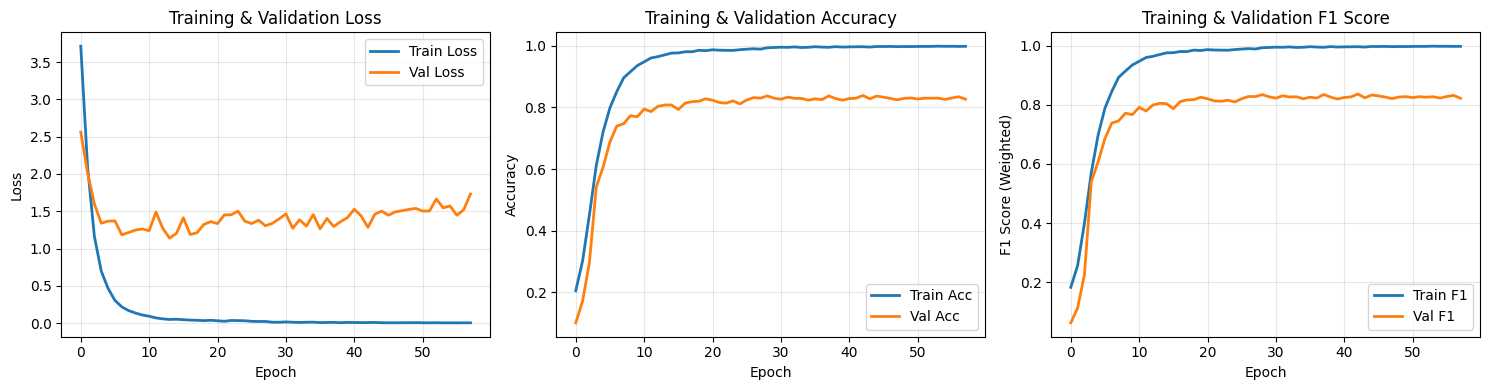

In [33]:
# ============================================
# 3.5 TRAINING VISUALIZATION
# ============================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss curves
ax1 = axes[0]
ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training & Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2 = axes[1]
ax2.plot(history['train_acc'], label='Train Acc', linewidth=2)
ax2.plot(history['val_acc'], label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training & Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# F1 curves
ax3 = axes[2]
ax3.plot(history['train_f1'], label='Train F1', linewidth=2)
ax3.plot(history['val_f1'], label='Val F1', linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1 Score (Weighted)')
ax3.set_title('Training & Validation F1 Score')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 4. Model Evaluation & Analysis

In [34]:
# ============================================
# 4.1 FINAL VALIDATION EVALUATION
# ============================================

# Final evaluation on validation set
val_loss, val_acc, val_f1, val_preds, val_labels = evaluate(model, val_loader, criterion, device)

print("=" * 60)
print("VALIDATION SET PERFORMANCE")
print("=" * 60)
print(f"Accuracy: {val_acc:.4f}")
print(f"F1 Score (Weighted): {val_f1:.4f}")
print(f"Loss: {val_loss:.4f}")

# Classification Report
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
target_names = [emotions[i] for i in range(6)]
print(classification_report(val_labels, val_preds, target_names=target_names, digits=4))


VALIDATION SET PERFORMANCE
Accuracy: 0.8388
F1 Score (Weighted): 0.8369
Loss: 1.2837

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     sadness     0.8473    0.9057    0.8756       435
         joy     0.8520    0.8926    0.8718       503
        love     0.7931    0.7480    0.7699       123
       anger     0.8957    0.7300    0.8044       200
        fear     0.7865    0.7865    0.7865       178
    surprise     0.7174    0.5893    0.6471        56

    accuracy                         0.8388      1495
   macro avg     0.8153    0.7754    0.7925      1495
weighted avg     0.8388    0.8388    0.8369      1495



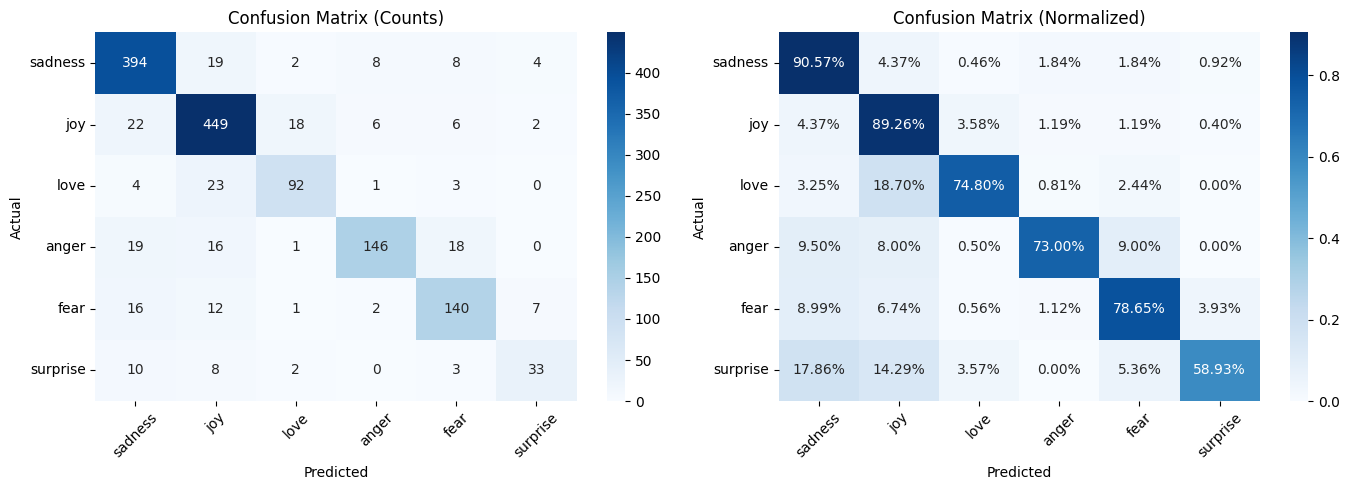


PER-CLASS ACCURACY
sadness   : 0.9057 (394/435)
joy       : 0.8926 (449/503)
love      : 0.7480 (92/123)
anger     : 0.7300 (146/200)
fear      : 0.7865 (140/178)
surprise  : 0.5893 (33/56)


In [35]:
# ============================================
# 4.2 CONFUSION MATRIX
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw confusion matrix
cm = confusion_matrix(val_labels, val_preds)
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=target_names, yticklabels=target_names)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Confusion Matrix (Counts)')
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='y', rotation=0)

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
ax2 = axes[1]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax2,
            xticklabels=target_names, yticklabels=target_names)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title('Confusion Matrix (Normalized)')
ax2.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

# Per-class accuracy
print("\n" + "=" * 60)
print("PER-CLASS ACCURACY")
print("=" * 60)
for i, emotion in enumerate(target_names):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"{emotion:10s}: {class_acc:.4f} ({cm[i, i]}/{cm[i].sum()})")


## 5. Generate Predictions & Submission

TEST PREDICTIONS DISTRIBUTION
sadness   :  598 (29.9%)
joy       :  727 (36.4%)
love      :  148 (7.4%)
anger     :  252 (12.6%)
fear      :  212 (10.6%)
surprise  :   63 (3.1%)


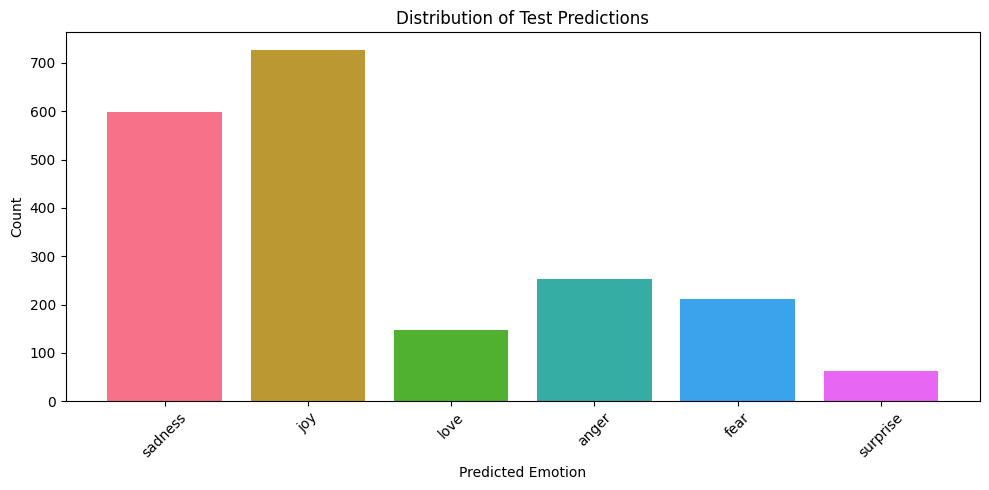

In [36]:
# ============================================
# 5.1 GENERATE TEST PREDICTIONS
# ============================================

model.eval()
test_preds = []
test_probs = []

with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

test_preds = np.array(test_preds)
test_probs = np.array(test_probs)

# Distribution of predictions
print("=" * 60)
print("TEST PREDICTIONS DISTRIBUTION")
print("=" * 60)
pred_counts = pd.Series(test_preds).value_counts().sort_index()
for label, count in pred_counts.items():
    print(f"{emotions[label]:10s}: {count:4d} ({count/len(test_preds)*100:.1f}%)")

# Visualize prediction distribution
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar([emotions[i] for i in pred_counts.index], pred_counts.values, color=colors)
ax.set_xlabel('Predicted Emotion')
ax.set_ylabel('Count')
ax.set_title('Distribution of Test Predictions')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


In [37]:
# ============================================
# 5.2 CREATE SUBMISSION FILE
# ============================================

# Create submission dataframe
submission = pd.DataFrame({
    'id': test_df['id'],
    'label': test_preds
})

# Save submission
submission.to_csv('submission.csv', index=False)

print("=" * 60)
print("SUBMISSION FILE CREATED")
print("=" * 60)
print(f"File saved: submission.csv")
print(f"Shape: {submission.shape}")
print(f"\nFirst 10 predictions:")
print(submission.head(10))

# Verify submission format matches sample
sample_sub = pd.read_csv('sample_submission.csv')
print(f"\nSample submission columns: {sample_sub.columns.tolist()}")
print(f"Our submission columns: {submission.columns.tolist()}")
print(f"Match: {list(sample_sub.columns) == list(submission.columns)}")


SUBMISSION FILE CREATED
File saved: submission.csv
Shape: (2000, 2)

First 10 predictions:
   id  label
0   1      0
1   2      0
2   3      0
3   4      1
4   5      0
5   6      4
6   7      3
7   8      1
8   9      1
9  10      3

Sample submission columns: ['id', 'label']
Our submission columns: ['id', 'label']
Match: True


## 6. Advanced: K-Fold Cross-Validation with Ensemble

In [ ]:
# ============================================
# 6.1 K-FOLD CROSS-VALIDATION TRAINING
# ============================================
# This provides a more robust model by training on multiple folds
# and ensembling predictions

N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

oof_preds = np.zeros((len(X_train_dense), 6))  # Out-of-fold predictions
test_preds_ensemble = np.zeros((len(X_test_dense), 6))
fold_scores = []

print("=" * 60)
print(f"K-FOLD CROSS-VALIDATION ({N_FOLDS} Folds)")
print("=" * 60)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_dense, y_train)):
    print(f"\n--- Fold {fold + 1}/{N_FOLDS} ---")

    # Split data
    X_fold_train = X_train_dense[train_idx]
    y_fold_train = y_train[train_idx]
    X_fold_val = X_train_dense[val_idx]
    y_fold_val = y_train[val_idx]

    # Create dataloaders
    fold_train_dataset = TensorDataset(
        torch.FloatTensor(X_fold_train),
        torch.LongTensor(y_fold_train)
    )
    fold_val_dataset = TensorDataset(
        torch.FloatTensor(X_fold_val),
        torch.LongTensor(y_fold_val)
    )

    # Weighted sampler for this fold
    fold_class_counts = np.bincount(y_fold_train)
    fold_class_weights = 1.0 / fold_class_counts
    fold_sample_weights = fold_class_weights[y_fold_train]
    fold_sampler = WeightedRandomSampler(fold_sample_weights, len(fold_sample_weights), replacement=True)

    fold_train_loader = DataLoader(fold_train_dataset, batch_size=BATCH_SIZE, sampler=fold_sampler)
    fold_val_loader = DataLoader(fold_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize new model for this fold
    fold_model = EmotionMLP(
        input_dim=INPUT_DIM,
        hidden_dims=[1024, 512, 256, 128],
        num_classes=6,
        dropout=0.4
    ).to(device)

    fold_optimizer = optim.AdamW(fold_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    fold_scheduler = optim.lr_scheduler.ReduceLROnPlateau(fold_optimizer, mode='max', factor=0.5, patience=5)
    fold_early_stopping = EarlyStopping(patience=10, delta=0.001)

    # Training loop
    for epoch in range(50):  # Fewer epochs per fold
        train_loss, train_acc, train_f1 = train_epoch(fold_model, fold_train_loader, fold_optimizer, criterion, device)
        val_loss, val_acc, val_f1, _, _ = evaluate(fold_model, fold_val_loader, criterion, device)

        fold_scheduler.step(val_f1)
        fold_early_stopping(val_f1, fold_model)

        if fold_early_stopping.early_stop:
            break

    # Restore best weights
    fold_early_stopping.restore(fold_model)
    fold_model = fold_model.to(device)

    # Get OOF predictions for this fold
    fold_model.eval()
    with torch.no_grad():
        val_outputs = fold_model(torch.FloatTensor(X_fold_val).to(device))
        oof_preds[val_idx] = torch.softmax(val_outputs, dim=1).cpu().numpy()

        # Test predictions
        test_outputs = fold_model(torch.FloatTensor(X_test_dense).to(device))
        test_preds_ensemble += torch.softmax(test_outputs, dim=1).cpu().numpy() / N_FOLDS

    # Fold score
    fold_score = f1_score(y_fold_val, oof_preds[val_idx].argmax(axis=1), average='weighted')
    fold_scores.append(fold_score)
    print(f"Fold {fold + 1} F1 Score: {fold_score:.4f}")

# Overall CV score
oof_labels = oof_preds.argmax(axis=1)
cv_score = f1_score(y_train, oof_labels, average='weighted')

print("\n" + "=" * 60)
print("CROSS-VALIDATION RESULTS")
print("=" * 60)
print(f"Fold Scores: {[f'{s:.4f}' for s in fold_scores]}")
print(f"Mean CV F1: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")
print(f"OOF F1 Score: {cv_score:.4f}")


K-FOLD CROSS-VALIDATION (5 Folds)

--- Fold 1/5 ---
Fold 1 F1 Score: 0.8323

--- Fold 2/5 ---


In [ ]:
# ============================================
# 6.2 CREATE ENSEMBLE SUBMISSION
# ============================================

# Ensemble predictions (average of all folds)
ensemble_preds = test_preds_ensemble.argmax(axis=1)

# Create submission
submission_ensemble = pd.DataFrame({
    'id': test_df['id'],
    'label': ensemble_preds
})

submission_ensemble.to_csv('submission_ensemble.csv', index=False)

print("=" * 60)
print("ENSEMBLE SUBMISSION CREATED")
print("=" * 60)
print(f"File saved: submission_ensemble.csv")
print(f"\nEnsemble prediction distribution:")
ensemble_counts = pd.Series(ensemble_preds).value_counts().sort_index()
for label, count in ensemble_counts.items():
    print(f"{emotions[label]:10s}: {count:4d} ({count/len(ensemble_preds)*100:.1f}%)")


## 7. Hyperparameter Tuning Guide

Below are key hyperparameters to tune for better performance:

### MLP Architecture
- **Hidden dimensions**: Try `[512, 256, 128]`, `[1024, 512, 256]`, `[2048, 1024, 512, 256]`
- **Dropout rate**: Range from 0.3 to 0.5
- **Activation functions**: ReLU, LeakyReLU, GELU

### Training Hyperparameters
- **Learning rate**: 1e-4 to 1e-2 (try with scheduler)
- **Batch size**: 32, 64, 128
- **Weight decay**: 1e-5 to 1e-3
- **Epochs**: Use early stopping with patience 10-20

### Feature Engineering
- **TF-IDF max_features**: 3000, 5000, 10000
- **N-gram range**: (1,1), (1,2), (1,3)
- **Add more handcrafted features**: sentiment scores, emotion lexicons

### Advanced Techniques
- **Label smoothing**: Add smoothing to CrossEntropyLoss
- **Mixup/CutMix**: Data augmentation for text
- **Ensemble**: Combine with other models (XGBoost, LightGBM, Transformers)